# Render Contours

author = Caroline Magg <br>
date = 05 May 2020 <br>

___________________________________
history: <br>
2020-05-05 Process Corpus Callosum <br>
2020-05-12 Try more structures <br>

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import pydicom
from natsort import natsorted
import scipy
import time
import logging as log
import skimage.segmentation as segmentation

In [2]:
log.basicConfig(format='%(levelname)s:%(message)s', level=log.INFO)

### Add dependencies

In [3]:
# add KidsBrainProject main folder to paths
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../utils/'))

In [4]:
#from utils_explore import read_structure,read_contour,read_contour_names,read_contour_row
from PatientData import PatientData
from DicomWrapper import DicomWrapper
from Segmentation import Segmentation

In [5]:
# add path to data here
path_data = "../../Data/" 

### Explore folder structure and naming

In [6]:
idx = 1
folder_name = os.path.join(path_data, str(idx))
folder = os.listdir(folder_name)
folder

['Contours',
 'CT',
 'RD.Jacks1IMPT.dcm',
 'RD.Jacks1IMPTb.dcm',
 'RS.Jacks1.dcm',
 'T1 +C 3-15-16',
 'T1 +C 3-23-16',
 'T1 +C 4-29-16',
 'T2 CISS 3-15-16',
 'T2 CUBE 4-29-16']

In [7]:
contours_list = pd.read_csv("list_contours.csv",delimiter=';')
contours_list

,Number,RoiName
0,1,Brain
1,2,Cerebel
2,3,Cingulum
3,4,Corpus callosum
4,5,CTV
5,6,Entorhinal
6,7,Fornix
7,8,FrontalLobe
8,9,GTV
9,10,Hippocampus


In [8]:
contour_of_interest = ["PTV","GTV","CTV"]

# PatientData

In [9]:
files = os.listdir(os.path.join(path_data, str(idx)))
path_contour = os.path.join(path_data, str(idx), 'RS.Jacks1.dcm')
path_preop = os.path.join(path_data, str(idx), 'CT')
path_postop1 = [os.path.join(path_data, str(idx), fn) for fn in [x for x in files if 'T1' in x]]
dcm = pydicom.dcmread(path_contour)
path_contour, path_preop, path_postop1

('../../Data/1\\RS.Jacks1.dcm',
 '../../Data/1\\CT',
 ['../../Data/1\\T1 +C 3-15-16',
  '../../Data/1\\T1 +C 3-23-16',
  '../../Data/1\\T1 +C 4-29-16'])

In [10]:
data = PatientData(path_preop, path_postop1, path_contour)

INFO:
Preop dicom
INFO:Debug on
INFO:Image size.......: (512, 512, 292)
INFO:Pixel spacing....: (0.9765625, 0.9765625, 1.0)
INFO:Slices number....: 292
INFO:Slices location...: 346.5 - 55.5
INFO:Position.........: (-250.0, -217.0, 346.5)
INFO:Resulting correction: [251.0, 218.0, 0]
INFO:
Postop ../../Data/1\T1 +C 3-15-16
INFO:Debug on
INFO:Image size.......: (512, 512, 292)
INFO:Pixel spacing....: (0.9765625, 0.9765625, 1.0)
INFO:Slices number....: 292
INFO:Slices location...: 346.5 - 55.5
INFO:Position.........: (-250.0, -217.0, 346.5)
INFO:Resulting correction: [251.0, 218.0, 0]
INFO:
Postop ../../Data/1\T1 +C 3-23-16
INFO:Debug on
INFO:Image size.......: (512, 512, 292)
INFO:Pixel spacing....: (0.9765625, 0.9765625, 1.0)
INFO:Slices number....: 292
INFO:Slices location...: 346.5 - 55.5
INFO:Position.........: (-250.0, -217.0, 346.5)
INFO:Resulting correction: [251.0, 218.0, 0]
INFO:
Postop ../../Data/1\T1 +C 4-29-16
INFO:Debug on
INFO:Image size.......: (512, 512, 292)
INFO:Pixel sp

In [11]:
data.get_all_contour_names()

array(['Amydgala left', 'Amydgala right', 'Ant Thalamus L',
       'Ant Thalamus R', 'Body', 'Brain', 'BrainInfratent',
       'BrainSupraTent', 'Brainstem', 'BrainstemCore', 'BrainstemSurf',
       'C1A', 'CG L', 'CG R', 'CTV', 'Cerebel ANT YL', 'Cerebell POST YL',
       'Cerebellum Jacks', 'CerebellumAnt LT', 'Cingulum left',
       'Cingulum right', 'CochleaLt', 'CochleaRt', 'Corpus callosum',
       'Dentate nucleus', 'Dose 102.8[%]', 'Dose 103.7[%]', 'Dose 104[%]',
       'Dose 95[%]', 'Entorhinal cor.L', 'Entorhinal cor.R',
       'ExtraThalamic L', 'ExtraThalamic R', 'FS', 'Fornix',
       'FrontalLobe_L', 'FrontalLobe_R2', 'GTV', 'HP', 'HippoHeadLt',
       'HippoHeadRt', 'HippoTailLt', 'HippoTailRt', 'HippocampusLt',
       'HippocampusRt', 'Hypothalamus', 'LFWM', 'LIP', 'LM', 'LSW',
       'LacrimalLt', 'LacrimalRt', 'LensLt', 'LensRt', 'Mam. bodies',
       'Mam.thal.tract L', 'Mam.thal.tract R', 'MastoidLt', 'MastoidRt',
       'Medulla C1', 'Medulla C2C3', 'NPX', 'NonTarg

In [12]:
struct = ["Brain", "PTV1","PTV2", "GTV","CTV","Scalp","Corpus callosum"]
data.read_filtered_contour(roiname=struct,mode="exact")

INFO:Start filtering contour list for RoiNames ['Brain', 'PTV1', 'PTV2', 'GTV', 'CTV', 'Scalp', 'Corpus callosum'] with mode exact
INFO:Reading contour information of RoiName Brain
INFO:Reading contour information of RoiName PTV1
INFO:Reading contour information of RoiName PTV2
INFO:Reading contour information of RoiName GTV
INFO:Reading contour information of RoiName CTV
INFO:Reading contour information of RoiName Scalp
INFO:Reading contour information of RoiName Corpus callosum


In [13]:
struct = ["Cingulum", "Cerebel", "Fornix", "FrontalLobe", "Hippocampus", "Hypothalamus", "Thalamus" ]
data.read_filtered_contour(roiname=struct,mode="approx")

INFO:Start filtering contour list for RoiNames ['Cingulum', 'Cerebel', 'Fornix', 'FrontalLobe', 'Hippocampus', 'Hypothalamus', 'Thalamus'] with mode approx
INFO:Reading contour information of RoiName Cingulum right
INFO:Reading contour information of RoiName Cingulum left
INFO:Reading contour information of RoiName Cerebellum Jacks
INFO:Reading contour information of RoiName CerebellumAnt LT
INFO:Reading contour information of RoiName Cerebel ANT YL
INFO:Reading contour information of RoiName Cerebell POST YL
INFO:Reading contour information of RoiName Fornix
INFO:Reading contour information of RoiName FrontalLobe_L
INFO:Reading contour information of RoiName FrontalLobe_R2
INFO:Reading contour information of RoiName HippocampusRt
INFO:Reading contour information of RoiName HippocampusLt
INFO:Reading contour information of RoiName Hypothalamus
INFO:Reading contour information of RoiName Thalamus right
INFO:Reading contour information of RoiName Thalamus ant R
INFO:Reading contour infor

In [14]:
data.get_filtered_contour_names()

67       Cingulum right
72        Cingulum left
90     Cerebellum Jacks
93     CerebellumAnt LT
101      Cerebel ANT YL
102    Cerebell POST YL
69               Fornix
62        FrontalLobe_L
98       FrontalLobe_R2
52        HippocampusRt
53        HippocampusLt
14         Hypothalamus
63       Thalamus right
64       Thalamus ant R
71        Thalamus left
73       Thalamus ant L
86       Ant Thalamus R
87       Ant Thalamus L
Name: RoiName, dtype: object

In [16]:
found = data.get_filtered_contour_names().values
index = data.contour_list_names_filtered['first'].values
index2 = data.contour_list_names_filtered['last'].values
found, index, index2

(array(['Cingulum right', 'Cingulum left', 'Cerebellum Jacks',
        'CerebellumAnt LT', 'Cerebel ANT YL', 'Cerebell POST YL', 'Fornix',
        'FrontalLobe_L', 'FrontalLobe_R2', 'HippocampusRt',
        'HippocampusLt', 'Hypothalamus', 'Thalamus right',
        'Thalamus ant R', 'Thalamus left', 'Thalamus ant L',
        'Ant Thalamus R', 'Ant Thalamus L'], dtype=object),
 array([71, 71, 93, 93, 93, 99, 82, 28, 28, 98, 96, 103, 84, 87, 82, 87,
        84, 82], dtype=object),
 array([113, 113, 157, 130, 132, 157, 109, 135, 135, 126, 126, 122, 101,
        91, 101, 91, 101, 101], dtype=object))

Cingulum right


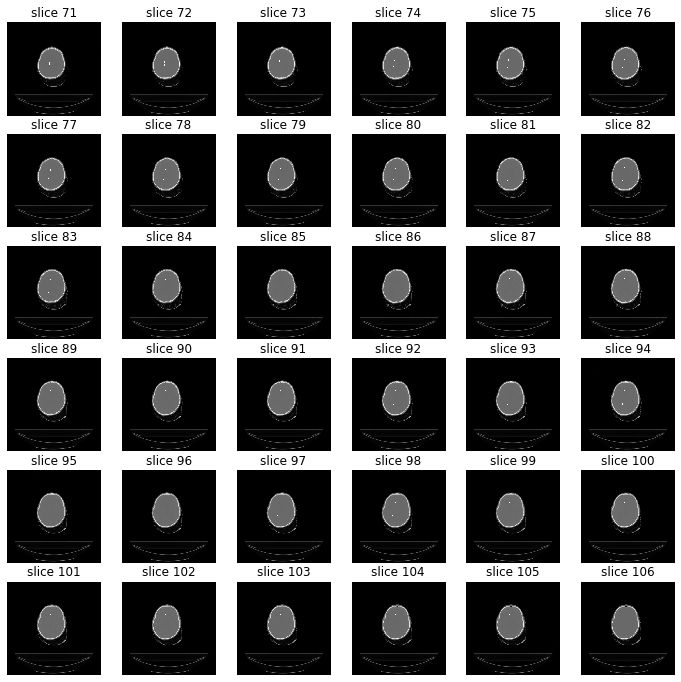

In [20]:
# visualize slices of pre op with contours
ind = 0
print(found[ind])
data.show_slices2D_contour(found[ind], show_every=1, start_with=index[ind])

# Segmentation

In [16]:
segmentor = Segmentation(data, debug=True)

In [17]:
segmentor.patient.contour_list_names_filtered['first'].values

array([28, 119, 121, 124, 122, 15, 72], dtype=object)

In [18]:
found = data.get_filtered_contour_names().values
index = data.contour_list_names_filtered['first'].values
found, index

(array(['Brain', 'PTV1', 'PTV2', 'GTV', 'CTV', 'Scalp', 'Corpus callosum'],
       dtype=object),
 array([28, 119, 121, 124, 122, 15, 72], dtype=object))

In [73]:
ind = 6
first = 76
contour = segmentor.active_contour(found[ind], postprocess = 0, 
                                   first=first, last=first+5, 
                                   kernel=(5,5), beta=0.1, w_edge=0.1, max_iterations=5,
                                   debug=True)
np.shape(contour)

INFO: Select data.
INFO: Start segmentation of Corpus callosum.
C:\Users\Caroline\Documents\KidsBrainProject\KidsBrainProject\utils\Segmentation.py:92: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  convergence=convergence, boundary_condition=boundary_condition)
INFO: ... slice: 76, time: 0.10207343101501465
INFO: ... slice: 77, time: 0.10907697677612305
INFO: ... slice: 78, time: 0.10607481002807617
INFO: ... slice: 79, time: 0.10607481002807617
INFO: ... slice: 80, time: 0.10207152366638184


(5, 1, 512, 512)

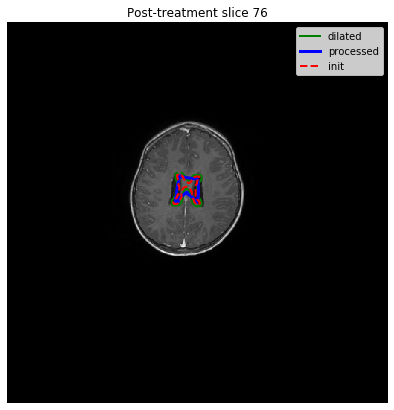

In [74]:
segmentor.show_segmentation_single(index=0)

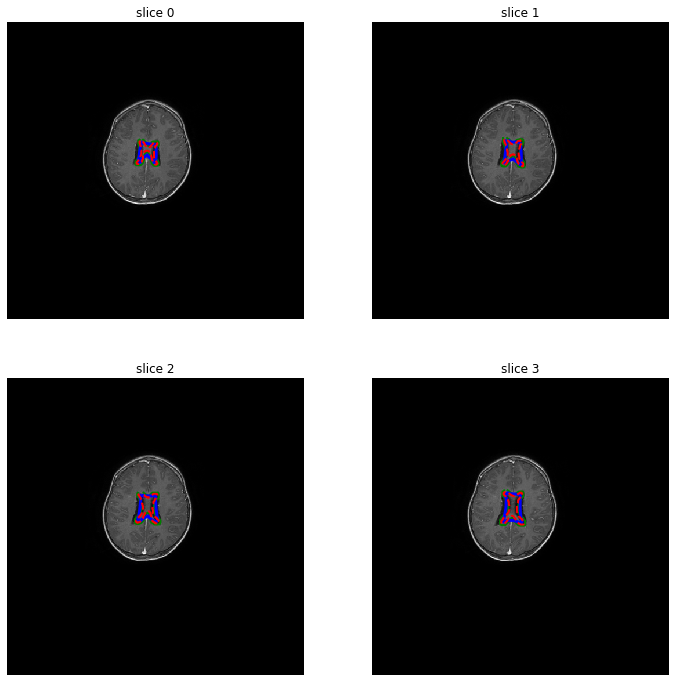

In [75]:
segmentor.show_segmentation_stack(2,2)